<a href="https://colab.research.google.com/github/mizzmir/NLP/blob/master/machine%20translation%20projects/Seq2SeqAttention/Seq2SeqAttention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
pip install tensorflow-gpu --quiet

In [2]:
!git clone https://github.com/mizzmir/data.git

fatal: destination path 'data' already exists and is not an empty directory.


In [0]:
import os
import re
import sys
import unicodedata
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import imageio

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

In [0]:
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')

def normalize(s):
    s = unicode_to_ascii(s)
    s = re.sub(r'([!.?])', r' \1', s)
    s = re.sub(r'[^a-zA-Z.!?-]+', r' ', s)
    s = re.sub(r'\s+', r' ', s)
    return s

def read_data(data_dir, file_name):
    full_path = os.path.join(data_dir, file_name)
    print("reading data from ", full_path)

    with open(full_path) as file:
      lines = file.readlines()
    
    data = []

    for line in lines:
        data.append(line.split("\t")[:-1])
    
    return data

def read_data_files(data_dir, file_names):
    
    en_file_name, fr_file_name = file_names
    
    full_path = os.path.join(data_dir, en_file_name)
    print("reading data from ", full_path)

    with open(full_path) as file:
      en_lines = file.readlines()
    
    full_path = os.path.join(data_dir, fr_file_name)
    print("reading data from ", full_path)

    with open(full_path) as file:
      fr_lines = file.readlines()    
    
    return en_lines, fr_lines

def preprocessSeq(texts, tokenizer):
  texts = tokenizer.texts_to_sequences(texts)

  return pad_sequences(texts, padding='post')

def tokenizeInput(input_data, tokenizer):
    output_data = []
    for data in input_data:
        tokenizer.fit_on_texts(data)
    
    for data in input_data:
        output_data.append(preprocessSeq(data, tokenizer))
    
    return output_data

In [5]:
data_dir = "/content/data"

# reading data
#en_lines, fr_lines = read_data_files(data_dir, ("small_vocab_en", "small_vocab_fr"))

data = read_data(data_dir, "fra.txt")
en_lines, fr_lines = list(zip(*data))

en_lines = en_lines[:40000]
fr_lines = fr_lines[:40000]


en_lines = [normalize(line) for line in en_lines]
fr_lines = [normalize(line) for line in fr_lines]

en_train, en_test, fr_train, fr_test = train_test_split(en_lines, fr_lines, shuffle=True, test_size=0.1)

fr_train_in = ['<start> ' + line for line in fr_train]
fr_train_out = [line + ' <end>' for line in fr_train]

fr_test_in = ['<start> ' + line for line in fr_test]
fr_test_out = [line + ' <end>' for line in fr_test]

fr_tokenizer = Tokenizer(filters='')
en_tokenizer = Tokenizer(filters='')

input_data = [fr_train_in, fr_train_out, fr_test_in, fr_test_out, fr_test, fr_train]
fr_train_in, fr_train_out, fr_test_in, fr_test_out, fr_test, fr_train = tokenizeInput(input_data,
                                                                                      fr_tokenizer)

input_data = [en_train, en_test]
en_train, en_test = tokenizeInput(input_data, en_tokenizer)

en_vocab_size = len(en_tokenizer.word_index)+1
fr_vocab_size = len(fr_tokenizer.word_index)+1
print("en_vocab {}\nfr_vocab {}" .format(en_vocab_size, fr_vocab_size))

reading data from  /content/data/fra.txt
en_vocab 5178
fr_vocab 9851


In [0]:
#
# Encoder Decoder
#
import tensorflow as tf

"""
class that implements LuangAttention
  - uses current decoder output as input to calculate alligment vector
  - score = h_t_trans*W_a*h_s
  - h_t - decoder hideden_state
  - h_s - encoder_output
  - context_vector = softmax(score)
"""
class LuangAttention(tf.keras.Model):
  def __init__(self, lstm_size, attention_type):
    super(LuangAttention, self).__init__()

    self.W_a = tf.keras.layers.Dense(lstm_size, name="LuangAttention_W_a")
    self.W_a_tanh = tf.keras.layers.Dense(lstm_size, activation="tanh", name="LuangAttention_W_a_tanh")
    self.v_a = tf.keras.layers.Dense(1)
    self.type = attention_type
  
  def call(self, decoder_output, encoder_output):
    # encoder_output shape [batch_size, seq_max_len, hidden_units_of_encoder]
    # decoder_output shape [batch_size, 1, hidden_units of decoder]
    # score shape [batch_size, 1, seq_max_len]
    if self.type == "dot":
        score = tf.matmul(decoder_output, encoder_output, transpose_b=True)
    elif self.type == "general":
        score = tf.matmul(decoder_output, self.W_a(encoder_output), transpose_b=True)
    elif self.type == "concat":
        decoder_output = tf.broadcast_to(decoder_output, encoder_output.shape)
        concated = self.W_a_tanh(tf.concat((decoder_output, encoder_output), axis=-1))
        score = tf.transpose(self.v_a(concated), [0,2,1])
    else:
        raise Exception("wrong score function selected")
        
    alignment_vector = tf.nn.softmax(score, axis=2)
    context_vector = tf.matmul(alignment_vector, encoder_output)

    return context_vector, alignment_vector

class Encoder(tf.keras.Model):
  def __init__(self, lstm_units, embedding_size, vocab_size):
    super(Encoder, self).__init__()

    self.units = lstm_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size, name="Encoder_embedding")
    self.lstm_layer = tf.keras.layers.LSTM(units=lstm_units, dropout=0.2, return_sequences=True, return_state=True, name="Encoder_LSTM")

  def call(self, input_seq, initial_state):
    # input_seq =shape [batch_size, seq_max_len]
    # initial_state shape [batch_size, lstm_hidden_state_size]

    # embedding shape [batch_size, seq_max_len, embedding_size]
    embedded_input = self.embedding(input_seq)
    #encoder output shape [batch_size, seq_max_len, lstm_size]
    # state_h, state_c shape 2*[batch_size, lstm_size]
    encoder_out, state_h, state_c = self.lstm_layer(inputs=embedded_input, initial_state=initial_state)

    return encoder_out, state_h, state_c
  
  def init_states(self, batch_size):
    return (tf.zeros([batch_size, self.units]),
            tf.zeros([batch_size, self.units]))

class Decoder(tf.keras.Model):
  def __init__(self, lstm_units, embedding_size, vocab_size, attention_type):
    super(Decoder, self).__init__()

    self.units = lstm_units
    self.embedding_layer = tf.keras.layers.Embedding(vocab_size, embedding_size, name="Decoder_embedding")
    self.lstm_layer = tf.keras.layers.LSTM(lstm_units, dropout=0.2, return_sequences=True, return_state=True, name="Decoder_lstm")
    self.dense_layer = tf.keras.layers.Dense(vocab_size)
    self.attention = LuangAttention(lstm_units, attention_type)

    self.W_c = tf.keras.layers.Dense(lstm_units, activation="tanh", name="Attention_W_c")
    self.W_s = tf.keras.layers.Dense(vocab_size, name="Attenton_W_s")

  def call(self, decoder_input, hidden_states, encoder_output):
    # decoder_input shape [batch_size, 1]
    # hidden_states shape 2*[batch_size, lstm_size]
    # encoder_output shape [batch_size, seq_max_len, lstm_size]
    embedded_input = self.embedding_layer(decoder_input)
    # embedded_input shape [batch_size, 1, embedding_size]
    # lstm_out shape [batch_size, 1, lstm_size]
    # state_h, state_c shape 2*[batch_szie, lstm_size]
    lstm_out, state_h, state_c = self.lstm_layer(embedded_input, hidden_states)

    # context shape [batch_size, 1 lstm_size]
    # alignment shape [batch_size, 1, source_len]
    context, alignment = self.attention(lstm_out, encoder_output)

    # lstm_out shape [batch_size, lstm_size + lstm_size]
    lstm_out = tf.concat([tf.squeeze(context, axis=1), tf.squeeze(lstm_out, axis=1)], axis=1, name="Decoder_concat")

    # output_vector shape [batch_size, lstm_units]
    output_vector = self.W_c(lstm_out)

    # conversion to vocabulaty prob
    # output_vector shape [batch_size, vocab_size]
    output_vector = self.W_s(output_vector)
    return output_vector, state_h, state_c, alignment

In [0]:
LSTM_SIZE = 512
EMBEDDING_SIZE = 250
BATCH_SIZE= 64
EPOCHS = 20

In [0]:
class Seq2SeqAttentionTrainer:
    def __init__(self, batch_size, lstm_size, embedding_size, predict_every):
        self.batch_size = batch_size
        self.lstm_size = lstm_size
        self.embedding_size = embedding_size
        self.predict_every = predict_every
        self.strategy = tf.distribute.MirroredStrategy()
        self.encoder = None
        self.decoder = None
        self.optimizer = None
        self.fr_tokenizer = None
        self.en_tokenizer = None

    def predict(self, en_sentence, fr_sentence):
        real_en_sentence =' '.join([self.en_tokenizer.index_word[i] for i in en_sentence if i not in [0]]) 
        fr_sentence = ' '.join([self.fr_tokenizer.index_word[i] for i in fr_sentence if i not in [0]]) 
        en_sentence = tf.expand_dims(en_sentence, 0)
        initial_states = self.encoder.init_states(1)
        encoder_out, state_h, state_c = self.encoder(tf.constant(en_sentence), initial_states, training=False)

        decoder_in = tf.constant([[self.fr_tokenizer.word_index['<start>']]])
        sentence = []
        alignments = []
        while True:
            decoder_out, state_h, state_c, alignment = self.decoder( \
                            decoder_in, (state_h, state_c), encoder_out, training=False)
            # argmax to get max index 
            decoder_in = tf.expand_dims(tf.argmax(decoder_out, -1), 0)
            word = self.fr_tokenizer.index_word[decoder_in.numpy()[0][0]]

            alignments.append(alignment)

            if  word == '<end>':
                break
            sentence.append(word)

        predicted_sentence = ' '.join(sentence)
        
        print("----------------------------PREDICTION----------------------------")
        print("       En sentence {} " .format(real_en_sentence))
        print("       Predicted:  {} " .format(predicted_sentence))
        print("       Should be:  {} " .format(fr_sentence))
        print("--------------------------END PREDICTION--------------------------")
        
        return np.array(alignments), real_en_sentence.split(' '), predicted_sentence.split(' ')

    def train(self, train_dataset_data, test_dataset_data, tokenizers, epochs, attention_type, restore_checkpoint=True):
        """
            train_dataset_data should be made from (en_train, fr_train_in, fr_train_out)
            test_dataset_data should be made from (en_test, fr_test_in, fr_test_out)
        """
        
        print_heatmap=True
        
        self.en_tokenizer, self.fr_tokenizer = tokenizers
        en_vocab_size = len(self.en_tokenizer.word_index)+1
        fr_vocab_size = len(self.fr_tokenizer.word_index)+1
        print("en_vocab {}\nfr_vocab {}" .format(en_vocab_size, fr_vocab_size))
        
        print ('Number of devices: {}'.format(self.strategy.num_replicas_in_sync))
        GLOBAL_BATCH_SIZE = self.batch_size*self.strategy.num_replicas_in_sync

        print("creating dataset...")
        en_train, fr_train_in, fr_train_out = train_dataset_data
        en_test, fr_test_in, fr_test_out = test_dataset_data
        train_dataset = tf.data.Dataset.from_tensor_slices((en_train, fr_train_in, fr_train_out))
        train_dataset = train_dataset.shuffle(len(en_train), reshuffle_each_iteration=True)\
                                        .batch(GLOBAL_BATCH_SIZE, drop_remainder=True)
        train_dist_dataset = self.strategy.experimental_distribute_dataset(train_dataset)

        test_dataset = tf.data.Dataset.from_tensor_slices((en_test, fr_test_out))
        test_dataset = test_dataset.shuffle(len(en_test), reshuffle_each_iteration=True)\
                                       .batch(GLOBAL_BATCH_SIZE, drop_remainder=True)
        test_dist_dataset = self.strategy.experimental_distribute_dataset(test_dataset)
        print("dataset created")
        
        test_losses = []
        train_losses = []
        train_accuracyVec = []
        test_accuracyVec =[]
        test_accuracy = tf.keras.metrics.Mean()
        train_accuracy = tf.keras.metrics.Mean()
        one_step_test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

        prediction_idx = np.random.randint(low=0, high=len(en_test), size=1)[0]
        prediction_en, prediction_fr = en_test[prediction_idx], fr_test_out[prediction_idx]

        if not os.path.exists("heatmap"):
          os.mkdir("heatmap")

        alignments = []

        with self.strategy.scope():
            self.encoder = Encoder(self.lstm_size, self.embedding_size, en_vocab_size)
            self.decoder = Decoder(self.lstm_size, self.embedding_size, fr_vocab_size, attention_type)
            self.optimizer = tf.keras.optimizers.Adam(clipnorm=0.5)
            
            ckpt = tf.train.Checkpoint(encoder=self.encoder,
                                       decoder = self.decoder,
                                       optimizer=self.optimizer,
                                       epoch=tf.Variable(1))

            manager = tf.train.CheckpointManager(ckpt, "./checkpoints/Seq2SeqAttention", max_to_keep=5)

            
            if manager.latest_checkpoint and restore_checkpoint:
                ckpt.restore(manager.latest_checkpoint)
                print ('Latest checkpoint restored!!')
            else:
                print("training from scratch")

            loss_obj = tf.keras.losses.SparseCategoricalCrossentropy(
                        from_logits=True, reduction="none")
            def compute_loss(predictions, labels):
                mask = tf.math.logical_not(tf.math.equal(labels, 0))
                mask = tf.cast(mask, tf.int64)
                per_example_loss = loss_obj(labels, predictions, sample_weight=mask)
                return tf.nn.compute_average_loss(per_example_loss, global_batch_size=GLOBAL_BATCH_SIZE)
            
            # one training step
            def train_step(en_data, fr_data_in, fr_data_out, initial_states):
                loss = 0
                one_step_test_accuracy.reset_states()
                with tf.GradientTape() as tape:
                    encoder_output, state_h, state_c = self.encoder(en_data, initial_states, training=True)
                    # shape[1] because we want each word for all batches
                    for i in range(fr_data_out.shape[1]):
                        decoder_input = tf.expand_dims(fr_data_in[:,i], 1)
                        decoder_output, state_h, state_c, _ = self.decoder(decoder_input,
                                                                        (state_h, state_c),
                                                                        encoder_output,
                                                                        training=True)
                        loss +=compute_loss(decoder_output, fr_data_out[:,i])
                        one_step_test_accuracy.update_state(decoder_output, fr_data_out[:,i])

                trainable_vars = self.encoder.trainable_variables + self.decoder.trainable_variables
                grads = tape.gradient(loss, trainable_vars)
                self.optimizer.apply_gradients(zip(grads, trainable_vars))

                train_accuracy.update_state(one_step_test_accuracy.result())
                return loss / fr_data_out.shape[1]

            @tf.function
            def distributed_train_step(en_data, fr_data_in, fr_data_out, initial_states):
                per_replica_losses = self.strategy.experimental_run_v2(train_step,
                                                                  args=(en_data,
                                                                        fr_data_in,
                                                                        fr_data_out,
                                                                        initial_states,))
                return self.strategy.reduce(tf.distribute.ReduceOp.SUM, per_replica_losses, axis=None)

            def test_step(en_data, fr_data_out):
                loss = 0
                one_step_test_accuracy.reset_states()
                initial_states = self.encoder.init_states(self.batch_size)
                encoder_output, state_h, state_c = self.encoder(en_data, initial_states, training=False)

                decoder_input = tf.constant(self.fr_tokenizer.word_index['<start>'], shape=(self.batch_size, 1))

                for i in range(fr_data_out.shape[1]): 
                    decoder_output, state_h, state_c, _ = self.decoder(decoder_input,
                                                                    (state_h, state_c),
                                                                    encoder_output,
                                                                    training=False)
                    decoder_input =tf.expand_dims(tf.argmax(decoder_output, 1),1)
                    loss +=compute_loss(decoder_output, fr_data_out[:,i])
                    one_step_test_accuracy.update_state(decoder_output, fr_data_out[:,i])
                
                train_accuracy.update_state(one_step_test_accuracy.result())
                return loss/fr_data_out.shape[1]

            @tf.function
            def distributed_test_step(en_data, fr_data_out):
                per_replica_losses = self.strategy.experimental_run_v2(test_step,
                                                                 args=(en_data,
                                                                       fr_data_out,))
                return self.strategy.reduce(tf.distribute.ReduceOp.SUM, per_replica_losses, axis=None)
            print("starting training with {} epochs with prediction each {} epoch" .format(epochs, self.predict_every))
            for epoch in range(epochs):
                test_accuracy.reset_states()
                train_accuracy.reset_states()
                initial_states = self.encoder.init_states(self.batch_size)
                
                total_loss = 0.0
                num_batches = 0
                for _, (en_data, fr_data_in, fr_data_out) in enumerate(train_dist_dataset):
                    loss = distributed_train_step(en_data, fr_data_in, fr_data_out, initial_states)
                    total_loss += loss
                    num_batches += 1
                train_losses.append(total_loss/num_batches)
                total_loss = 0.0
                num_batches = 0
                for _, (en_data, fr_data_out) in enumerate(test_dist_dataset):
                    loss = distributed_test_step(en_data, fr_data_out)
                    total_loss += loss
                    num_batches += 1
                
                test_losses.append(total_loss/num_batches)
                print ('Epoch {} training Loss {:.4f} Accuracy {:.4f}  test Loss {:.4f} Accuracy {:.4f}' .format( \
                                                  epoch + 1, 
                                                  train_losses[-1], 
                                                  train_accuracy.result(),
                                                  test_losses[-1],
                                                  test_accuracy.result()))
                
                train_accuracyVec.append(train_accuracy.result())
                test_accuracyVec.append(test_accuracy.result())
                ckpt.epoch.assign_add(1)
                if int(epoch) % 5 == 0:
                    save_path = manager.save()
                    print("Saving checkpoint for epoch {}: {}".format(epoch, save_path))
                if epoch % self.predict_every == 0:         
                    alignment, source, predicted = self.predict(prediction_en, prediction_fr)
                    attention_map = np.squeeze(alignment, (1, 2))
                    alignments.append(attention_map)
                    if print_heatmap:
                        fig = plt.figure(figsize=(10, 10))
                        ax = fig.add_subplot(1, 1, 1)
                        ax.matshow(attention_map, cmap='jet')
                        ax.set_xticklabels([''] + source, rotation=90)
                        ax.set_yticklabels([''] + predicted[:-1])

                        plt.savefig('heatmap/prediction_{}.png' .format(epoch//self.predict_every))
                        plt.show()
                        plt.close()
            save_path = manager.save()
            print ('Saving checkpoint for end at {}'.format(save_path))

        return (train_losses, test_losses), (train_accuracyVec, test_accuracyVec)

In [0]:
trainer = Seq2SeqAttentionTrainer(BATCH_SIZE, LSTM_SIZE, EMBEDDING_SIZE, 5)

en_vocab 5178
fr_vocab 9851
Number of devices: 1
creating dataset...
dataset created
Latest checkpoint restored!!
starting training with 20 epochs with prediction each 5 epoch
Epoch 1 training Loss 1.0097 Accuracy 0.0000  test Loss 2.3639 Accuracy 0.0000
Saving checkpoint for epoch 0: ./checkpoints/Seq2SeqAttention/ckpt-2
----------------------------PREDICTION----------------------------
       En sentence did i break it ? 
       Predicted:  l ai-je fait ? 
       Should be:  l ai-je brisee ? <end> 
--------------------------END PREDICTION--------------------------


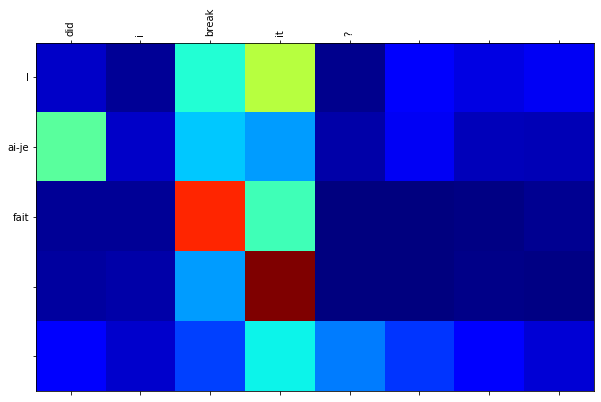

Epoch 2 training Loss 0.6606 Accuracy 0.0000  test Loss 2.0524 Accuracy 0.0000
Epoch 3 training Loss 0.4557 Accuracy 0.0000  test Loss 2.0156 Accuracy 0.0000
Epoch 4 training Loss 0.3388 Accuracy 0.0000  test Loss 1.9940 Accuracy 0.0000
Epoch 5 training Loss 0.2677 Accuracy 0.0000  test Loss 2.0516 Accuracy 0.0000


In [0]:
losses, accuracy = trainer.train([en_train, fr_train_in, fr_train_out], [en_test, fr_test_in, fr_test_out], [en_tokenizer, fr_tokenizer], EPOCHS, "concat")

In [0]:
train_losses, test_losses = losses 
train_accuracyVec, test_accuracyVec = accuracy

In [0]:
import matplotlib.pyplot as plt
fig = plt.figure()
fig_plot = fig.add_subplot()
fig_plot.plot(train_losses, label="train_loss")
fig_plot.plot(test_losses, label="test_loss")
fig_plot.legend(loc="upper right")
fig_plot.set_xlabel("epoch")
fig_plot.set_ylabel("loss")
fig_plot.grid(linestyle="--")
fig.savefig("losses_plot.png")
fig.show()

In [0]:
fig = plt.figure()
fig_plot = fig.add_subplot()
fig_plot.plot(train_accuracyVec, label="train_accuracy")
fig_plot.plot(test_accuracyVec, label="test_accuracy")
fig_plot.legend(loc="lower right")
fig_plot.set_xlabel("epoch")
fig_plot.set_ylabel("accuracy")
fig_plot.grid(linestyle="--")
fig.savefig("accuracy_plot.png")